# **K-MEANS CLUSTERING**

**This is an unsupervised classification project of a DataSet, using the K-means clustering system.**

**I will process the database that I have collected from the following address**: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

**It is a database for analyzing customer purchases in a store.**

**Import the libraries**

In [43]:
!pip install --q validclust

In [44]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from typing import List, Tuple, Dict
import seaborn as sns

**Import the DataSet**

In [46]:
url='https://drive.google.com/file/d/1Xb96dEvVC9CJqoJ87bofZw-f7sJ1BAcL/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
data = pd.read_csv(dwn_url, sep="\t")

data.head(6)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**Null data**

In [48]:
nulls_per_column = data.isnull().sum()
print(nulls_per_column)

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


In [49]:
# Since there are 24 null values out of a total of 2240, I decide to eliminate them.
if data.isnull().values.any():
    data.dropna(inplace=True)
    print("Rows after cleaning up missing values:",data.shape[0])

Rows after cleaning up missing values: 2216


**Non-numeric columns: I see that there are 3 columns with categorical values. I have to decide what to do with them.
These are: “Education”, “Marital_Status” and “Dt_Customer".**

In [50]:
# I am going to see the different values that the columns “Education” and “Marital_Status” take. And how many values there are of each of the classes.

valores_education = data['Education'].value_counts()
print(valores_education)

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [51]:
valores_mar_status = data['Marital_Status'].value_counts()
print(valores_mar_status)

Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


**The values of “Education” and “Marital_Status” I will transform them into numerical values, in order to be able to treat them..**

In [52]:
# To substitute the data, I first define the mapping dictionary, as follows:

education_map = {
    'Basic': 1,
    'Graduation': 2,
    '2n Cycle': 3,
    'Master': 4,
    'PhD': 5
}

# I apply the mapping to the column 'Education' and check the result

data['Education'] = data['Education'].replace(education_map)
print(data['Education'])

0       2
1       2
2       2
3       2
4       5
       ..
2235    2
2236    5
2237    2
2238    4
2239    5
Name: Education, Length: 2216, dtype: int64


In [53]:
# In the case of marital status, I will first put together the people who have declared “alone” with “single”. And I will join “together” with “married”, since for the company it will not make a difference.
# I will eliminate the 2 cases that are “absurd” and the 2 that are “YOLO”.

data['Marital_Status'] = data['Marital_Status'].replace('Alone', 'Single')

data['Marital_Status'] = data['Marital_Status'].replace('Together', 'Married')

data = data[~data['Marital_Status'].isin(['Absurd', 'YOLO'])]

print(data['Marital_Status'].value_counts())


Marital_Status
Married     1430
Single       474
Divorced     232
Widow         76
Name: count, dtype: int64


In [54]:
# I am now going to give these groups a numerical value, just as I did with the education groups.

mapeo_estado_civil = {
    'Single': 1,
    'Married': 2,
    'Divorced': 3,
    'Widow': 4
    }

# I apply the mapping and check the result

data['Marital_Status'] = data['Marital_Status'].replace(mapeo_estado_civil)
print(data['Marital_Status'])

0       1
1       1
2       2
3       2
4       2
       ..
2235    2
2236    2
2237    3
2238    2
2239    2
Name: Marital_Status, Length: 2212, dtype: int64


In [55]:
print(data.head())

     ID  Year_Birth  Education  Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957          2               1  58138.0        0         0   
1  2174        1954          2               1  46344.0        1         1   
2  4141        1965          2               2  71613.0        0         0   
3  6182        1984          2               2  26646.0        1         0   
4  5324        1981          5               2  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

**With the column “Dt_Customer”, which is the date of registration of the customer, what I am going to do is to transform this data into the length of service as a customer, in months.
In this way, we will have a numerical data, which we will also be able to analyze.**

In [56]:
# Step 1: Convert column 'Dt_Customer' to type datetime with the format day-month-year
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y', errors='coerce')

# Step 2: Obtain the current date
current_date = pd.Timestamp.now()

# Step 3: Calculate seniority in months
data['antiguedad_meses'] = current_date.year * 12 + current_date.month - (data['Dt_Customer'].dt.year * 12 + data['Dt_Customer'].dt.month)

# Step 4: Check the result
print(data[['Dt_Customer', 'antiguedad_meses']])

     Dt_Customer  antiguedad_meses
0     2012-09-04               141
1     2014-03-08               123
2     2013-08-21               130
3     2014-02-10               124
4     2014-01-19               125
...          ...               ...
2235  2013-06-13               132
2236  2014-06-10               120
2237  2014-01-25               125
2238  2014-01-24               125
2239  2012-10-15               140

[2212 rows x 2 columns]


In [57]:
# I see that it is correct. Now I delete the column 'Dt_Customer', and I check how the dataframe looks like.

data = data.drop(columns=['Dt_Customer'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2212 non-null   int64  
 1   Year_Birth           2212 non-null   int64  
 2   Education            2212 non-null   int64  
 3   Marital_Status       2212 non-null   int64  
 4   Income               2212 non-null   float64
 5   Kidhome              2212 non-null   int64  
 6   Teenhome             2212 non-null   int64  
 7   Recency              2212 non-null   int64  
 8   MntWines             2212 non-null   int64  
 9   MntFruits            2212 non-null   int64  
 10  MntMeatProducts      2212 non-null   int64  
 11  MntFishProducts      2212 non-null   int64  
 12  MntSweetProducts     2212 non-null   int64  
 13  MntGoldProds         2212 non-null   int64  
 14  NumDealsPurchases    2212 non-null   int64  
 15  NumWebPurchases      2212 non-null   int64 

**I already have all the columns of numeric type. But I see that the first column (ID) does not tell us anything, so I eliminate it.
And the column “year of birth” I am going to convert it to “age”, which is a more visual value, at the time of processing it.**

In [58]:
# I delete the ID column
data = data.drop(columns=['ID'])

In [59]:
# I'm going to get the age of the customers

# Step 1: Obtain the current year
current_year = pd.Timestamp.now().year

# Step 2: Calculate the age of customers
data['Age'] = current_year - data['Year_Birth']

# Step 3: Check the result
print(data[['Year_Birth', 'Age']])

      Year_Birth  Age
0           1957   67
1           1954   70
2           1965   59
3           1984   40
4           1981   43
...          ...  ...
2235        1967   57
2236        1946   78
2237        1981   43
2238        1956   68
2239        1954   70

[2212 rows x 2 columns]


In [60]:
# I delete the Year_Birth column, now that I already have the Age column.
data = data.drop(columns=['Year_Birth'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   int64  
 1   Marital_Status       2212 non-null   int64  
 2   Income               2212 non-null   float64
 3   Kidhome              2212 non-null   int64  
 4   Teenhome             2212 non-null   int64  
 5   Recency              2212 non-null   int64  
 6   MntWines             2212 non-null   int64  
 7   MntFruits            2212 non-null   int64  
 8   MntMeatProducts      2212 non-null   int64  
 9   MntFishProducts      2212 non-null   int64  
 10  MntSweetProducts     2212 non-null   int64  
 11  MntGoldProds         2212 non-null   int64  
 12  NumDealsPurchases    2212 non-null   int64  
 13  NumWebPurchases      2212 non-null   int64  
 14  NumCatalogPurchases  2212 non-null   int64  
 15  NumStorePurchases    2212 non-null   int64 

In [61]:
print(data.head())

   Education  Marital_Status   Income  Kidhome  Teenhome  Recency  MntWines  \
0          2               1  58138.0        0         0       58       635   
1          2               1  46344.0        1         1       38        11   
2          2               2  71613.0        0         0       26       426   
3          2               2  26646.0        1         0       26        11   
4          5               2  58293.0        1         0       94       173   

   MntFruits  MntMeatProducts  MntFishProducts  ...  AcceptedCmp4  \
0         88              546              172  ...             0   
1          1                6                2  ...             0   
2         49              127              111  ...             0   
3          4               20               10  ...             0   
4         43              118               46  ...             0   

   AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  \
0             0             0         

**Outliers**

In [62]:
# Function that counts the number of outliers
def count_outliers(df: pd.DataFrame, columna:str) -> int:
  Q1 = np.percentile(df[columna], 25)
  Q2 = np.percentile(df[columna], 50)
  Q3 = np.percentile(df[columna], 75)

  IQR = Q3 - Q1

  iqr_lower_limit = Q1 - 1.5 * IQR
  iqr_upper_limit = Q3 + 1.5 * IQR

  outliers_iqr = df[columna][(df[columna] < iqr_lower_limit) | (df[columna] > iqr_upper_limit)]
  return len(outliers_iqr)

In [63]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Education,2212.0,3.044756,1.277182,1.0,2.00,2.0,4.00,5.0
Marital_Status,2212.0,1.959313,0.674649,1.0,2.00,2.0,2.00,4.0
Income,2212.0,52232.510850,25187.455359,1730.0,35233.50,51381.5,68522.00,666666.0
Kidhome,2212.0,0.442586,0.537052,0.0,0.00,0.0,1.00,2.0
Teenhome,2212.0,0.505425,0.544258,0.0,0.00,0.0,1.00,2.0
Recency,2212.0,49.050633,28.940794,0.0,24.00,49.0,74.00,99.0
MntWines,2212.0,305.030741,337.611255,0.0,23.75,173.5,505.50,1493.0
MntFruits,2212.0,26.324593,39.781794,0.0,1.75,8.0,33.00,199.0
MntMeatProducts,2212.0,166.970163,224.344950,0.0,16.00,68.0,232.25,1725.0
MntFishProducts,2212.0,37.516275,54.558673,0.0,3.00,12.0,50.00,259.0


**To eliminate outliers, I will apply the interquartile range (IQR) method.**

Here are the steps on how to do it:

1 - Calculate the IQR and the lower and upper limits for each numeric column.

2 - Filter the rows that are within these limits for all numeric columns. But I tell it which columns I want to keep, so that they do not apply to those.

This approach ensures that all rows containing outliers in any numeric column are removed from the DataFrame.
Note that if a row contains an outlier in a column, it will be completely removed from the DataFrame, even if it does not contain outliers in other columns.

In [64]:
def remove_rows_with_outliers(df, columns_to_keep):
    df_wout_outliers = df.copy()  # I create a copy of the DataFrame in order not to modify the original one.
    # I determine the columns in which the outliers will be verified
    columns_to_check = [col for col in df.columns if col not in columns_to_keep]

    for column in columns_to_check:
        if column in df.columns and df[column].dtype in ['float64', 'int64']:
            Q1 = df[column].quantile(0.30)  # Instead of 0.25, I put 0.30, to improve the elimination of the outliers of this Dataframe.
            Q3 = df[column].quantile(0.70)  # Instead of 0.75, I put 0.70
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_wout_outliers = df_wout_outliers[(df_wout_outliers[column] >= lower_bound) & (df_wout_outliers[column] <= upper_bound)]
    return df_wout_outliers

# I specify the columns I want to keep
columns_to_keep = ['Education', 'Marital_Status']  # I keep the columns that have values that I have created, since I am interested in keeping them

# I apply the function to remove the rows with outliers in the unspecified columns
data = remove_rows_with_outliers(data, columns_to_keep)

# I check the result
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Education,1073.0,3.043802,1.288924,1.0,2.0,2.0,4.0,5.0
Marital_Status,1073.0,1.958062,0.651572,1.0,2.0,2.0,2.0,4.0
Income,1073.0,39816.013979,15106.674717,7500.0,28440.0,38452.0,50150.0,83664.0
Kidhome,1073.0,0.645853,0.544155,0.0,0.0,1.0,1.0,2.0
Teenhome,1073.0,0.568500,0.547395,0.0,0.0,1.0,1.0,2.0
Recency,1073.0,50.706431,28.747591,0.0,26.0,51.0,76.0,99.0
MntWines,1073.0,110.925443,171.373251,0.0,10.0,31.0,138.0,1001.0
MntFruits,1073.0,7.022367,9.939156,0.0,1.0,3.0,9.0,58.0
MntMeatProducts,1073.0,43.239515,59.050458,0.0,9.0,19.0,55.0,389.0
MntFishProducts,1073.0,10.475303,14.844643,0.0,2.0,4.0,13.0,86.0


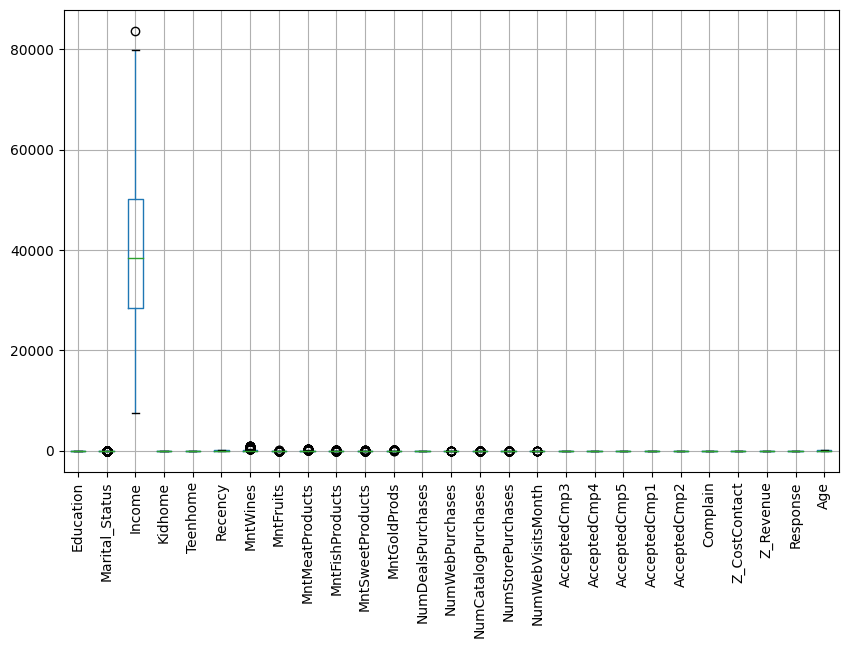

In [65]:
import matplotlib.pyplot as plt

# I create boxplots for each numeric column
data.select_dtypes(include=['float64', 'int64']).boxplot(figsize=(10, 6), rot=90)
plt.show()

In [66]:
# I see that there is still an outlier in the income.

count_outliers(data, "Income")

1

In [67]:
# I am going to reduce it, using the interquartile method.
columna = 'Income'

# Calculate Q1 (first quartile) and Q3 (third quartile)
Q1 = data[columna].quantile(0.25)
Q3 = data[columna].quantile(0.75)

# Calculating the IQR (interquartile range)
IQR = Q3 - Q1

# Define lower and upper limits for outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filter data to remove outliers
data = data[(data[columna] >= limite_inferior) & (data[columna] <= limite_superior)]

count_outliers(data, "Income")

0

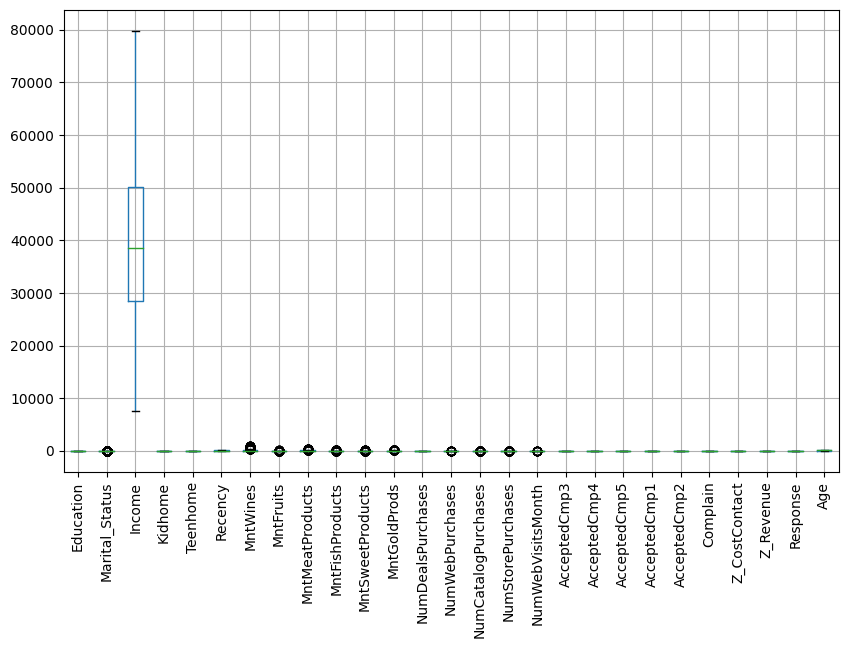

In [68]:
# I check that they are gone
data.select_dtypes(include=['float64', 'int64']).boxplot(figsize=(10, 6), rot=90)
plt.show()

# **Frequency of each of the columns**

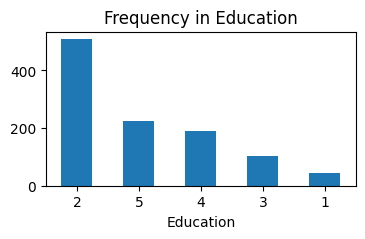

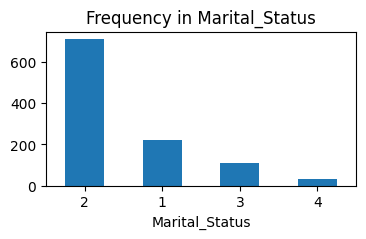

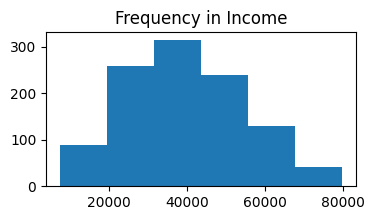

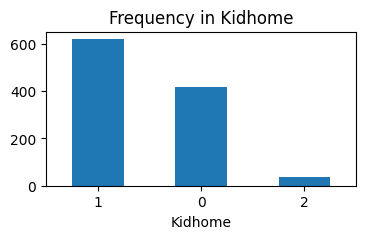

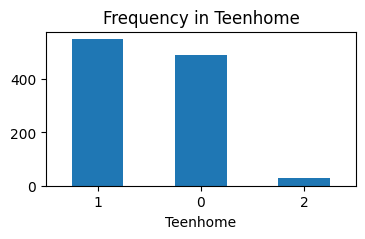

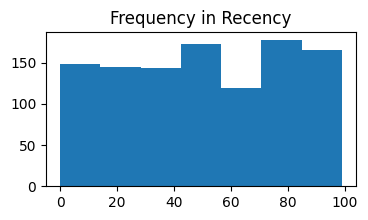

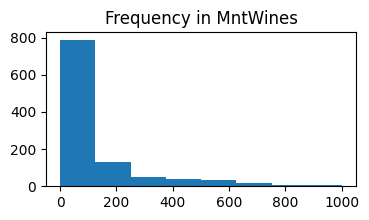

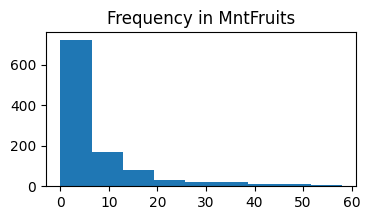

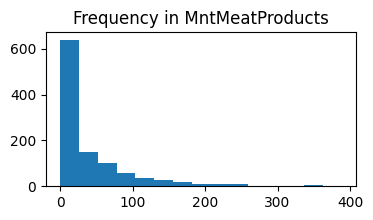

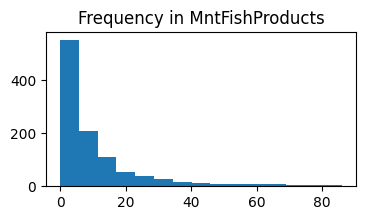

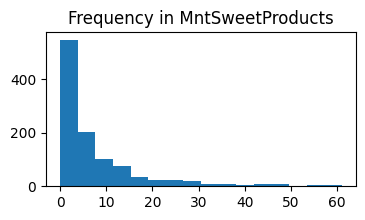

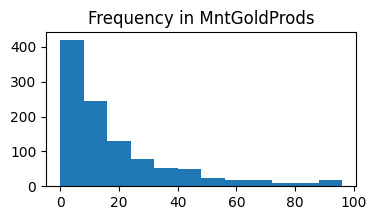

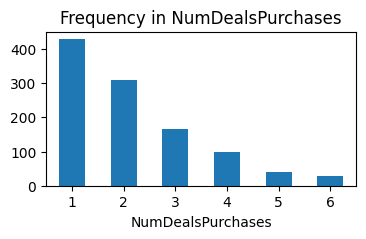

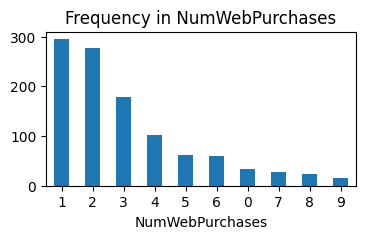

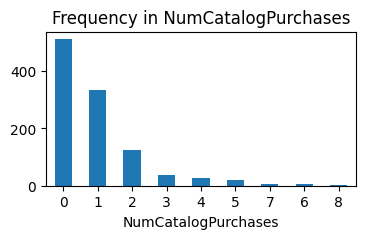

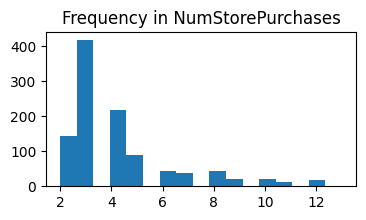

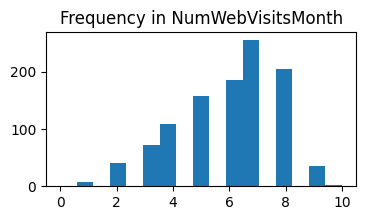

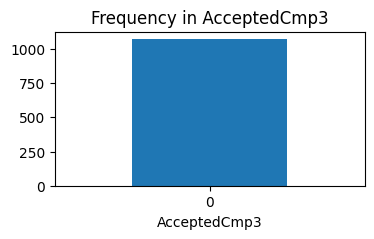

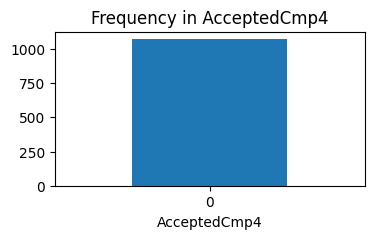

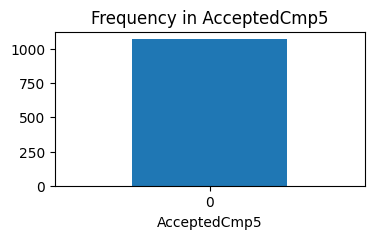

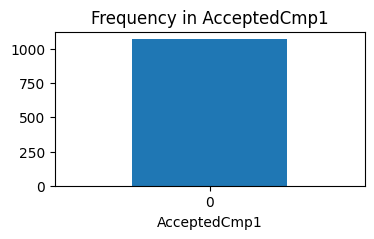

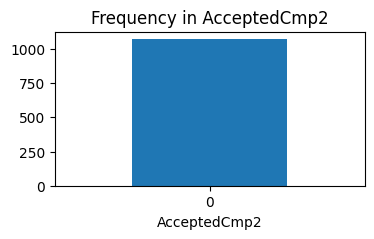

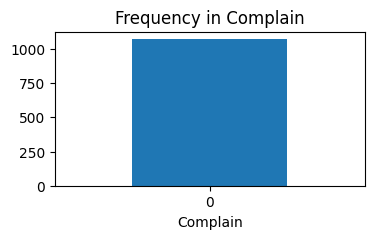

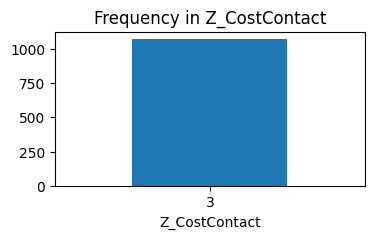

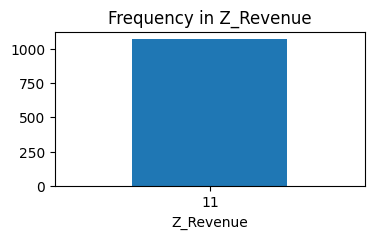

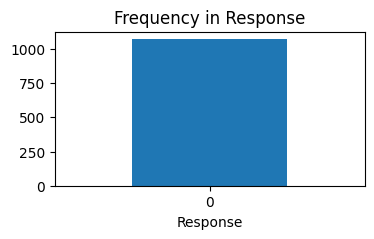

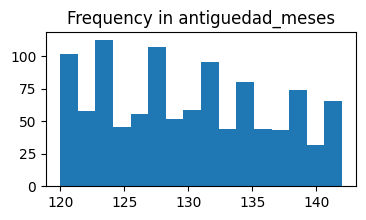

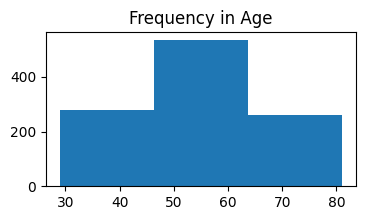

In [69]:
for column in data.columns:
  if data[column].dtype == "object" or len(data[column].unique())<=10:
    plt.figure(figsize=(4, 2))
    data[column].value_counts().plot(kind='bar')
    plt.title(f'Frequency in {column}')
    plt.xticks(rotation=0)
    plt.show()
  else:
    plt.figure(figsize=(4, 2))
    plt.hist(data[column], bins=len(column))
    plt.title(f'Frequency in {column}')
    plt.show()

**There are columns that I am not going to use, which are those dedicated to whether the customer accepted discounts in one campaign or another, complaints, and costs. So I am going to make a selection of the database, which does not include those columns.**

In [70]:
# First I save my initial database in a new dataframe, called data_init
data_init = data.copy()

# I define the columns I am not going to work with
columnas_a_eliminar = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']

# I create a new DataFrame without the unwanted columns
data = data.drop(columns=columnas_a_eliminar)

# I check the result
print(data.head())



   Education  Marital_Status   Income  Kidhome  Teenhome  Recency  MntWines  \
1          2               1  46344.0        1         1       38        11   
3          2               2  26646.0        1         0       26        11   
4          5               2  58293.0        1         0       94       173   
5          4               2  62513.0        0         1       16       520   
7          5               2  33454.0        1         0       32        76   

   MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
1          1                6                2                 1   
3          4               20               10                 3   
4         43              118               46                27   
5         42               98                0                42   
7         10               56                3                 1   

   MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
1             6                  2      

In [71]:
# I verify that the original DataFrame is still intact.
print(data_init.head())

   Education  Marital_Status   Income  Kidhome  Teenhome  Recency  MntWines  \
1          2               1  46344.0        1         1       38        11   
3          2               2  26646.0        1         0       26        11   
4          5               2  58293.0        1         0       94       173   
5          4               2  62513.0        0         1       16       520   
7          5               2  33454.0        1         0       32        76   

   MntFruits  MntMeatProducts  MntFishProducts  ...  AcceptedCmp4  \
1          1                6                2  ...             0   
3          4               20               10  ...             0   
4         43              118               46  ...             0   
5         42               98                0  ...             0   
7         10               56                3  ...             0   

   AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  \
1             0             0         

# **Data rescaling**

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

In [73]:
# In this case, I use the RobustScaler

scaler = RobustScaler()
standardized_data = scaler.fit_transform(data)

# **Cluster evaluation**

**I am going to check the optimal number of clusters, and then apply K-means**

In [74]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

def cluster_indexes(df, n_max_clust, methods):
    """
    This function returns the highest values of each index for each method used, testing all the number of clusters from two to a specified limit.
    to a specified limit.
    Parameters:
      -df: DataFrame to study.
      -n_max_clust: maximum number of clusters to test.
      -methods: clustering methods to test. Allowed values are “kmeans” and “hierarchical”.
    Returns:
      -results: a tuple with a value for each method. In each method it returns the indexes with the highest score, indicating the number of cluster
      in which that value was given.
    """
    import pprint
    kmeans_dict = {}
    agglm_dict = {}

    kmeans_max_values = {
        "Silhouette Index": (0, float('-inf')),
        "Calinski-Harabasz Index": (0, float('-inf')),
        "Davis Bouldin Index": (0, float('inf'))
    }

    agglm_max_values = {
        "Silhouette Index": (0, float('-inf')),
        "Calinski-Harabasz Index": (0, float('-inf')),
        "Davis Bouldin Index": (0, float('inf'))
    }

    for n_cluster in range(2, n_max_clust + 1):
        if "kmeans" in methods:
            kmeans = KMeans(n_clusters=n_cluster, init='k-means++', random_state=0, n_init="auto").fit(df)
            kmeans_labels = kmeans.labels_
            silhouette_avg = silhouette_score(df, kmeans_labels)
            ch_score = calinski_harabasz_score(df, kmeans_labels)
            db_score = davies_bouldin_score(df, kmeans_labels)

            kmeans_dict[n_cluster] = {
                "K-means. Silhouette Index": silhouette_avg,
                "K-means. Calinski-Harabasz Index": ch_score,
                "K-means. Davis Bouldin Index": db_score
            }

            if silhouette_avg > kmeans_max_values["Silhouette Index"][1]:
                kmeans_max_values["Silhouette Index"] = (n_cluster, silhouette_avg)
            if ch_score > kmeans_max_values["Calinski-Harabasz Index"][1]:
                kmeans_max_values["Calinski-Harabasz Index"] = (n_cluster, ch_score)
            if db_score < kmeans_max_values["Davis Bouldin Index"][1]:
                kmeans_max_values["Davis Bouldin Index"] = (n_cluster, db_score)

        if "hierarchical" in methods:
            agglm = AgglomerativeClustering(n_clusters=n_cluster).fit(df)
            agglm_labels = agglm.labels_
            silhouette_avg = silhouette_score(df, agglm_labels)
            ch_score = calinski_harabasz_score(df, agglm_labels)
            db_score = davies_bouldin_score(df, agglm_labels)

            agglm_dict[n_cluster] = {
                "Hierarchical. Silhouette Index": silhouette_avg,
                "Hierarchical. Calinski-Harabasz Index": ch_score,
                "Hierarchical. Davis Bouldin Index": db_score
            }

            if silhouette_avg > agglm_max_values["Silhouette Index"][1]:
                agglm_max_values["Silhouette Index"] = (n_cluster, silhouette_avg)
            if ch_score > agglm_max_values["Calinski-Harabasz Index"][1]:
                agglm_max_values["Calinski-Harabasz Index"] = (n_cluster, ch_score)
            if db_score < agglm_max_values["Davis Bouldin Index"][1]:
                agglm_max_values["Davis Bouldin Index"] = (n_cluster, db_score)

    results = {
        "kmeans": kmeans_max_values,
        "hierarchical": agglm_max_values
    }

    pprint.pprint(results)


results = cluster_indexes(standardized_data, 4, ["kmeans", "hierarchical"])

{'hierarchical': {'Calinski-Harabasz Index': (2, 468.0384363463086),
                  'Davis Bouldin Index': (2, 1.194503454444142),
                  'Silhouette Index': (2, 0.4839235369318888)},
 'kmeans': {'Calinski-Harabasz Index': (2, 604.5259167861673),
            'Davis Bouldin Index': (2, 1.2062825229979872),
            'Silhouette Index': (2, 0.470611422793834)}}


                                  2           3           4           5  \
method       index                                                        
kmeans       silhouette    0.470611    0.287809    0.285561    0.163956   
             calinski    604.525917  413.925043  328.907102  277.160890   
             davies        1.206283    1.677736    1.689847    1.988211   
             dunn          0.134034    0.101657    0.101712    0.060332   
hierarchical silhouette    0.483924    0.259267    0.262730    0.171434   
             calinski    468.038436  365.937841  285.107324  245.345071   
             davies        1.194503    1.685621    1.823288    2.019327   
             dunn          0.169722    0.097678    0.102825    0.092925   

                                  6  
method       index                   
kmeans       silhouette    0.111686  
             calinski    248.453574  
             davies        1.891068  
             dunn          0.079801  
hierarchical silhouet

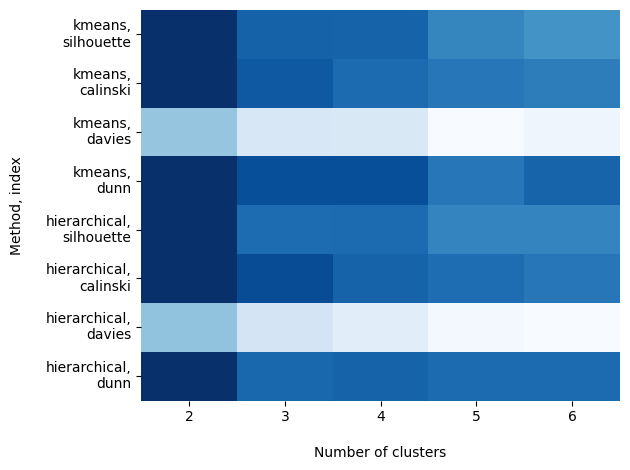

In [75]:
# EVALUATION OF THE NUMBER OF CLUSTERS WITH VALIDCLUST

from validclust import ValidClust

vclust = ValidClust(
    k=list(range(2, 7)), # Here is the range of groups to be tested
    methods=['kmeans','hierarchical'] # I indicate the clustering strategy to be evaluated.
)
cvi_vals = vclust.fit_predict(standardized_data)
print(cvi_vals)
vclust.plot()

**Elbow method**

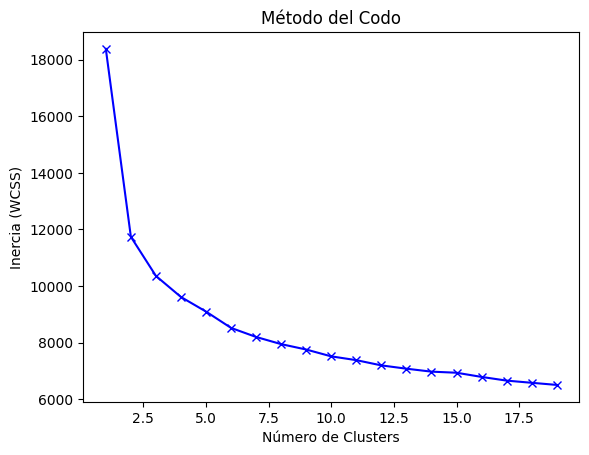

In [76]:
K = range(1, 20)
inertia = []  # List to store the inertia for each K

# Here I simply apply k-means for the number of clusters.
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(standardized_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method')
plt.show()

**I decide to work with 2 clusters**

# **K-MEANS CLUSTERING**


In [77]:
n_clusters = 2

# Initializing and adjusting the K-means model
kmeans = KMeans(n_clusters= n_clusters, init='k-means++', random_state=42) # Define a KMeans object.
kmeans.fit(standardized_data) # Generate clustering.

# Create a new DataFrame and store the cluster assignments in it.
data_kmeans = pd.DataFrame(data).copy()
data_kmeans["n_cluster"] = kmeans.labels_ # kmeans.labels_ saves the cluster assignments.
data_kmeans.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,antiguedad_meses,Age,n_cluster
1,2,1,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,123,70,0
3,2,2,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,124,40,0
4,5,2,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,125,43,1
5,4,2,62513.0,0,1,16,520,42,98,0,42,14,2,6,4,10,6,129,57,1
7,5,2,33454.0,1,0,32,76,10,56,3,1,23,2,4,0,4,8,133,39,0


In [78]:
# OBTAINING CENTROIDS
centroids = kmeans.cluster_centers_
print("Centroids:")
print(centroids)

Centroides:
[[ 4.80946882e-01 -4.96535797e-02 -1.38032170e-01 -2.40184758e-01
  -4.94226328e-01 -1.89376443e-03  1.42095482e-01  1.50115473e-01
   5.90922783e-02  1.84022675e-01  1.51703233e-01  1.00923788e-01
   5.77367206e-03  6.19707467e-02 -5.24249423e-01  1.77829099e-01
   1.42609700e-01 -2.39344951e-02  5.70574650e-03]
 [ 6.89320388e-01 -1.45631068e-02  8.97373187e-01 -8.34951456e-01
  -1.69902913e-01 -2.32038835e-02  2.62340716e+00  1.97694175e+00
   2.48237653e+00  2.28199470e+00  2.11225728e+00  1.39466019e+00
   4.00485437e-01  1.07281553e+00  1.93203883e+00  2.42233010e+00
  -6.50485437e-01  8.78199470e-02  3.36664763e-01]]


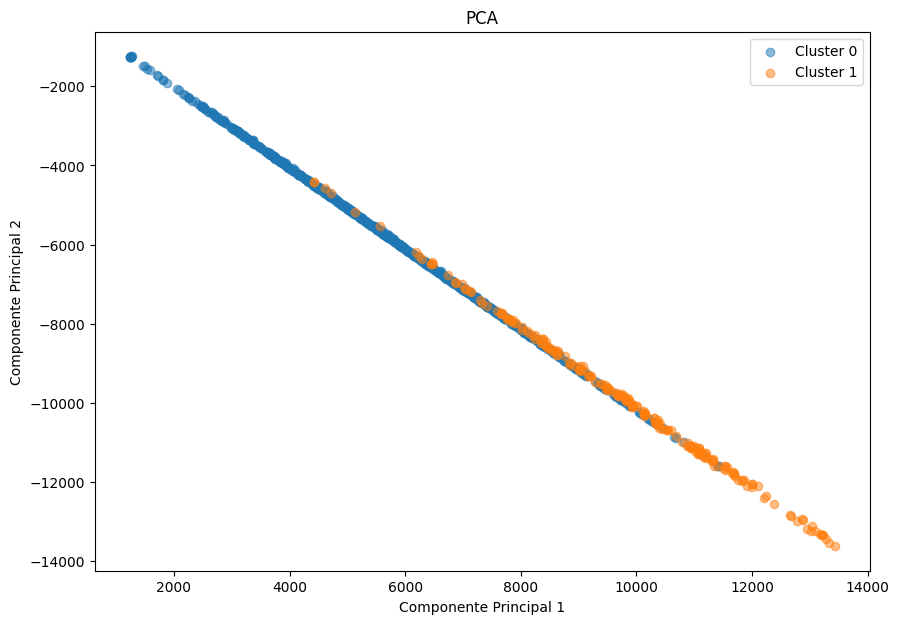

In [79]:
from sklearn.decomposition import PCA

# APPLY PCA FOR DISPLAY
n_components = 2
pca = PCA(n_components=2)
pca.fit(standardized_data)
data_pca = pca.transform(data_kmeans.iloc[:, :-1]) # Apply PCA to the DataFrame excluding the last one, which is the one that stores the cluster assignments.
data_pca = pd.DataFrame(data_pca, columns=["PC1","PC2"])
data_pca["n_cluster"] = kmeans.labels_

plt.figure(figsize=(10, 7))
for cluster in data_pca['n_cluster'].unique():
    cluster_data = data_pca[data_pca['n_cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.legend()
plt.show()

In [80]:
# CLUSTER INTERPRETATION
# I create a DataFrame for each cluster
data_kmeans_0 = data_kmeans[data_kmeans["n_cluster"]==0]
data_kmeans_1 = data_kmeans[data_kmeans["n_cluster"]==1]

In [81]:
data_kmeans_0.describe().T

,count,mean,std,min,25%,50%,75%,max
Education,866.0,2.961894,1.271176,1.0,2.00,2.0,4.00,5.0
Marital_Status,866.0,1.950346,0.645898,1.0,2.00,2.0,2.00,4.0
Income,866.0,35454.872979,12357.954934,7500.0,26525.75,34884.5,44291.75,69139.0
Kidhome,866.0,0.759815,0.515698,0.0,0.00,1.0,1.00,2.0
Teenhome,866.0,0.505774,0.535957,0.0,0.00,0.0,1.00,2.0
Recency,866.0,50.905312,28.849985,0.0,26.00,51.0,77.00,99.0
MntWines,866.0,49.188222,69.959198,0.0,8.00,22.0,56.00,451.0
MntFruits,866.0,4.200924,5.770669,0.0,0.00,2.0,6.00,45.0
MntMeatProducts,866.0,21.718245,21.710477,0.0,7.00,14.0,27.00,129.0
MntFishProducts,866.0,6.024249,7.197663,0.0,0.00,3.0,8.00,43.0


In [82]:
data_kmeans_1.describe().T

,count,mean,std,min,25%,50%,75%,max
Education,206.0,3.378641,1.307513,2.0,2.00,3.5,5.00,5.0
Marital_Status,206.0,1.985437,0.673384,1.0,2.00,2.0,2.00,4.0
Income,206.0,57936.888350,11370.455584,26490.0,50313.25,58687.5,65929.50,79803.0
Kidhome,206.0,0.165049,0.372129,0.0,0.00,0.0,0.00,1.0
Teenhome,206.0,0.830097,0.518221,0.0,1.00,1.0,1.00,2.0
Recency,206.0,49.839806,28.433895,0.0,28.00,50.0,74.00,99.0
MntWines,206.0,366.796117,219.668502,35.0,179.25,336.5,524.50,1001.0
MntFruits,206.0,18.815534,14.203227,0.0,7.25,16.0,28.00,58.0
MntMeatProducts,206.0,133.189320,78.113476,23.0,76.25,113.0,165.75,389.0
MntFishProducts,206.0,29.101942,22.358592,0.0,12.00,23.0,43.00,86.0


# **Conclusions**

**A few conclusions can be drawn:**

 Cluster 0 characteristics:
  - Lower level of education.
  - No difference in marital status with respect to cluster 1.
  - Lower income level
  - They have more children at home, but fewer teenagers, than cluster 1.
  - No difference in the number of days since last purchase.
  - Spending on wine is much lower than the other group.
  - Spending on all other products is significantly less
  - The number of purchases with discounts is similar
  - The number of purchases through the web is smaller
  - The number of purchases through catalogs is lower
  - The number of in-store purchases is lower
  - The number of visits to the website is slightly higher.
  - No difference in customer seniority
  - Slightly lower age range